# Population data

The population data was obtained from the following sources:
 - [National Institute of Statistic of Rwanda](https://www.statistics.gov.rw/) - direct data link: [May 2023 KEY TRENDS: 5th Rwanda Population and Housing Census PHC - Kinyarwanda](https://www.statistics.gov.rw/publication/key-trends-5th-rwanda-population-and-housing-census-phc-kinyarwanda)
 - [Uganda Bureau of Statistics](https://www.ubos.org/) - direct data link: [Census data and projections](https://www.ubos.org/wp-content/uploads/statistics/Census_Population_counts_(2002_and_2014)_by_Region,_District_and_Mid-Year_Population_projections_(2015-2021).xlsx)
 - [INSTAT Madagascar](https://www.instat.mg/) 


### Loading libraries

In [2]:
library(tidyverse)
library(openxlsx)

### 1. Loading geographical data

Loading the `df.geo.regions` dataframe created in [`geo_data.ipynb`](geo_data.ipynb).

In [3]:
load("data/df_geo_regions.RData") 

### 2. Loading the chemical data

It is loaded for geographical coordinates of the sampling points `locx` and `loc.y`.

In [4]:
df.chem <- openxlsx::read.xlsx("data/chemical_data.xlsx",sheet=1)

### 3. Loading prepared population data

The data was taken from the abovementioned sources and placed in the MS Excel file `population_data.xlsx`. For certain countries multiple population data sources are given. The source of the data is mentioned in `data.source` column.

In [5]:
df.population.by.district <- openxlsx::read.xlsx("data/population_data.xlsx")
head(df.population.by.district)

,country,region,district,population,data.source
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,Rwanda,City of Kigali,Nyarugenge,374319,census 2022
2,Rwanda,City of Kigali,Gasabo,879505,census 2022
3,Rwanda,City of Kigali,Kicukiro,491731,census 2022
4,Rwanda,Southern Province,Nyanza,365718,census 2022
5,Rwanda,Southern Province,Gisagara,397051,census 2022
6,Rwanda,Southern Province,Nyaruguru,318126,census 2022


### 4. Summarizing the district data fo the region data
The population data is given by district, so it needs to be grouped with respect to region, and data source. 

In [6]:
df.pop.reg <- df.population.by.district %>% group_by(country, region, data.source) %>% summarize(population=sum(population,na.rm = TRUE))
head(df.pop.reg)

`summarise()` has grouped output by 'country', 'region'. You can override using
the `.groups` argument.


country,region,data.source,population
<chr>,<chr>,<chr>,<dbl>
Madagascar,Alaotra-Mangoro,census 2018 (unofficial www),1249931
Madagascar,Alaotra-Mangoro,projection 2020 (unofficial www),1316136
Madagascar,Amoron'i Mania,census 2018 (unofficial www),837116
Madagascar,Amoron'i Mania,projection 2020 (unofficial www),889497
Madagascar,Analamanga,census 2018 (unofficial www),3040023
Madagascar,Analamanga,projection 2020 (unofficial www),3812126


##### Total population by country and data source

In [7]:
df.pop.reg %>% group_by(country,data.source) %>% summarize(regions.No=n_distinct(region),population=sum(population,na.rm = TRUE)) 

`summarise()` has grouped output by 'country'. You can override using the
`.groups` argument.


country,data.source,regions.No,population
<chr>,<chr>,<int>,<dbl>
Madagascar,census 2018 (unofficial www),22,23616805
Madagascar,projection 2020 (unofficial www),22,25512148
Rwanda,census 2022,5,13246394
Uganda,census 2014,4,34869432
Uganda,projection 2021,4,42593400


### 5. Joining the geographical (regions) dataframe and population dataframe

In order to present he population graphically, dataframes need to be merged (LEFT JOIN). To display the boundaries of regions properly, the dataframe needs to be arranged with respect to `path.id` and `point.ix` columns.

In [8]:
df.geo.pop <- arrange(merge(df.geo.regions,df.pop.reg,by=c("country","region"),all.x=TRUE),path.id,point.ix)
head(df.geo.pop)

,country,region,x,y,path.id,point.ix,data.source,population
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>
1,Rwanda,Eastern Province,30.44970,-1.049094,1,1,census 2022,3563145
2,Rwanda,Eastern Province,30.44998,-1.049565,1,2,census 2022,3563145
3,Rwanda,Eastern Province,30.45002,-1.049227,1,3,census 2022,3563145
4,Rwanda,Eastern Province,30.45005,-1.048911,1,4,census 2022,3563145
5,Rwanda,Eastern Province,30.45008,-1.048537,1,5,census 2022,3563145
6,Rwanda,Eastern Province,30.45076,-1.048452,1,6,census 2022,3563145


### 6. Displaying the population of Uganda, Rwanda and Madagascar by region and sampling points

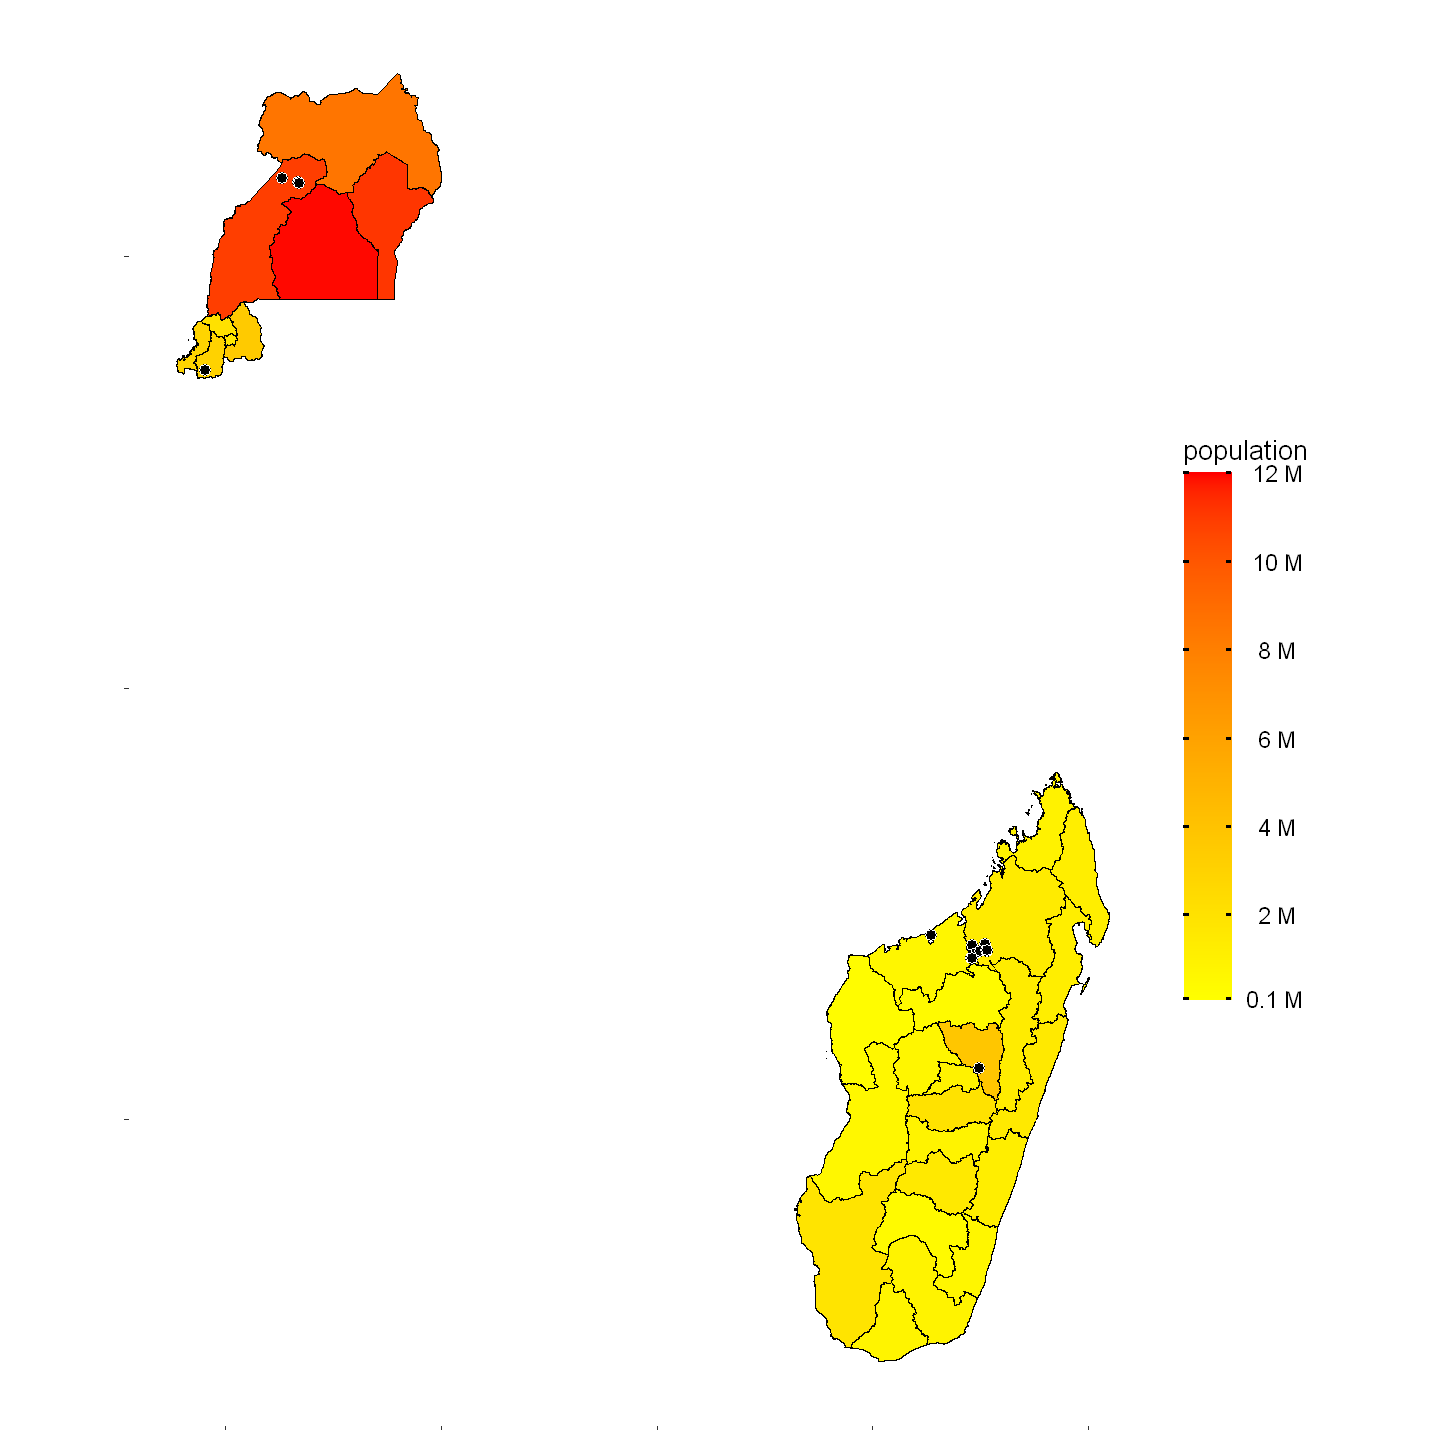

In [9]:
options(repr.plot.height=12,repr.plot.width=12)

fill.breaks <- sort(c(100000,seq(2*10^6,1.2*10^7,2*10^6))) # colorbar breaks

ggplot() + geom_polygon(data=df.geo.pop[with(df.geo.pop, # choosing only certain sources of population data
                                             data.source=="projection 2021" | data.source=="census 2022" | data.source=="projection 2020 (unofficial www)"),],
                        aes(x,y,fill=population,group=path.id),color="black") + coord_fixed() +
           geom_point(data=df.chem,aes(x=loc.x,y=loc.y),size=3,shape=21,color="white",fill="black")+ # display sampling points with black dots
           # adjusting appearance
           scale_fill_gradient(low = "yellow", high = "red", na.value = NA,
                               limits=c(100000,12010000),
                               breaks=fill.breaks,
                               labels=format(paste(fill.breaks/10^6,"M"),width = 6,  justify = "r"), # adjusting labels to format XX M
                               guide = guide_colourbar( barwidth = 2, barheight = 22,ticks.colour = "black",ticks.linewidth = 1)) + 
                               theme_bw() + theme(axis.text=element_blank(),
                                                  axis.title=element_blank(),
                                                  panel.grid.major=element_blank(),
                                                  panel.grid.minor=element_blank(),
                                                  panel.border=element_blank(),
                                                  legend.text=element_text(size=14),
                                                  legend.title=element_text(size=16)) 

#ggsave("IMG/population.svg",height=15,width=15)